![NCAR UCAR Logo](img/NCAR_CISL_NSF_banner.jpeg)
# Python GPU session: CuPy and Legate

By: Brett Neuman [bneuman@ucar.edu](mailto:bneuman@ucar.edu), Consulting Services Group, CISL & NCAR

Date: July 28th 2022

Head to the [NCAR JupyterHub portal](https://jupyterhub.hpc.ucar.edu/stable) and __start a JupyterHub session on Casper login__ (or batch nodes using 1 CPU, no GPUs) and open the notebook in `12_PythonGPU.ipynb`. Be sure to clone (if needed) and update/pull the NCAR GPU_workshop directory.

```shell
# Use the JupyterHub GitHub GUI on the left panel or the below shell commands
git clone git@github.com:NCAR/GPU_workshop.git
git pull
```

# Workshop Etiquette
* Please mute yourself and turn off video during the session.
* Questions may be submitted in the chat and will be answered when appropriate. You may also raise your hand, unmute, and ask questions during Q&A at the end of the presentation.
* By participating, you are agreeing to [UCAR’s Code of Conduct](https://www.ucar.edu/who-we-are/ethics-integrity/codes-conduct/participants)
* Recordings & other material will be archived & shared publicly.
* Feel free to follow up with the GPU workshop team via Slack or submit support requests to [support.ucar.edu](https://support.ucar.edu)
    * Office Hours: Asynchronous support via [Slack](https://ncargpuusers.slack.com) or schedule a time with an organizer

## Notebook Setup
This notebook will work best if running it within a JupyterHub PBS Batch (interactive) session.  Much of the Python code will fail if a GPU is not detected on the node.  Select the PBS Batch option when launching from JupyterHub and set the `PROJECT` code to a currently active project, ie `UCIS0004` for the GPU workshop, and `QUEUE` to the appropriate routing queue depending on if during a live workshop session (`gpuworkshop`), during weekday 8am to 5:30pm MT (`gpudev`), or all other times (`casper`). Due to limited shared GPU resources, please use `GPU_TYPE=gp100` during the workshop. Otherwise, set `GPU_TYPE=v100` (required for `gpudev`) for independent work. See [Casper queue documentation](https://arc.ucar.edu/knowledge_base/72581396#StartingCasperjobswithPBS-Concurrentresourcelimits) for more info.

If running this notebook outside of the NCAR computing environment, a compatible GPU is required on a node or your local machine to execute the code in the CuPy sections of this notebook.

## Python Virtual Environment Setup

See [Python virtual environment documentation](https://kb.ucar.edu/display/RC/Using+conda+environments+for+Python+access) for using the NCAR Python Library (npl) or for setting up your own virtual environment.

In [4]:
%%bash
module load conda/latest

#conda env create --file envs/environment.yml
#conda activate pgpu

In [ ]:
# importing sys
import sys
 
# adding workshop env to the system path
sys.path.insert(0, '/glade/work/bneuman/...)

Switch to the `conda env:pgpu` kernel within the JupyterHub notebook:

# Python GPU Itinerary

1) Python GPU Programming Overview
2) CuPy
    - Overview and Setup
    - Basic Drop-in Replacement Example
    - Computational Fluid Dynamics Example
    - GeoCAT Case Study
    - Additional CuPy Functionality
3) Legate
    - Overview, Philosophy, and Setup
    - Basic Drop-in Replacement Example

----


## Python Scientific Computing on the GPU
Tools to enhance performant Python packages to be executed on the GPU. These tools attempt to be drop-in replacements for the common CPU packages.

One consideration introduced with Python GPU programming is portability.  Different tools used for Python GPU programming need to be designed for specific device families.

Below is a chart showing scientific computing GPU APIs, device compatibility, and additional compute functionality for known Python GPU programming tool suites: 

![Python GPU Chart](img/pygpuchart.png)
  
    (* : Options to use compiled Python)



## Python vs. Compiled Languages for GPU Programming

In previous workshop sessions we showed examples of how to write GPU code using compiled languages.  The Miniweather Fortran OpenACC implementation required compiler directives to instruct sections of code to be run on the GPU.  

**Interpreted vs. Compiled**

Python is a partially interpreted language, meaning that the code requires an additional step to run as machine code. This additional step will need to be considered when writing performant code.  One big trade off for Python's platform independence, dynamic typing, and modularity is the additional step to interpret the bytecode generated by Python and then running machine code on your device.

Garbage collection is another difference that is handled for the user within Python.  This reduces the responsibility of the programmer for handling memory creation, deletion, and optimization.  

Comparing a Python GPU implementation to the CUDA / C implementation:

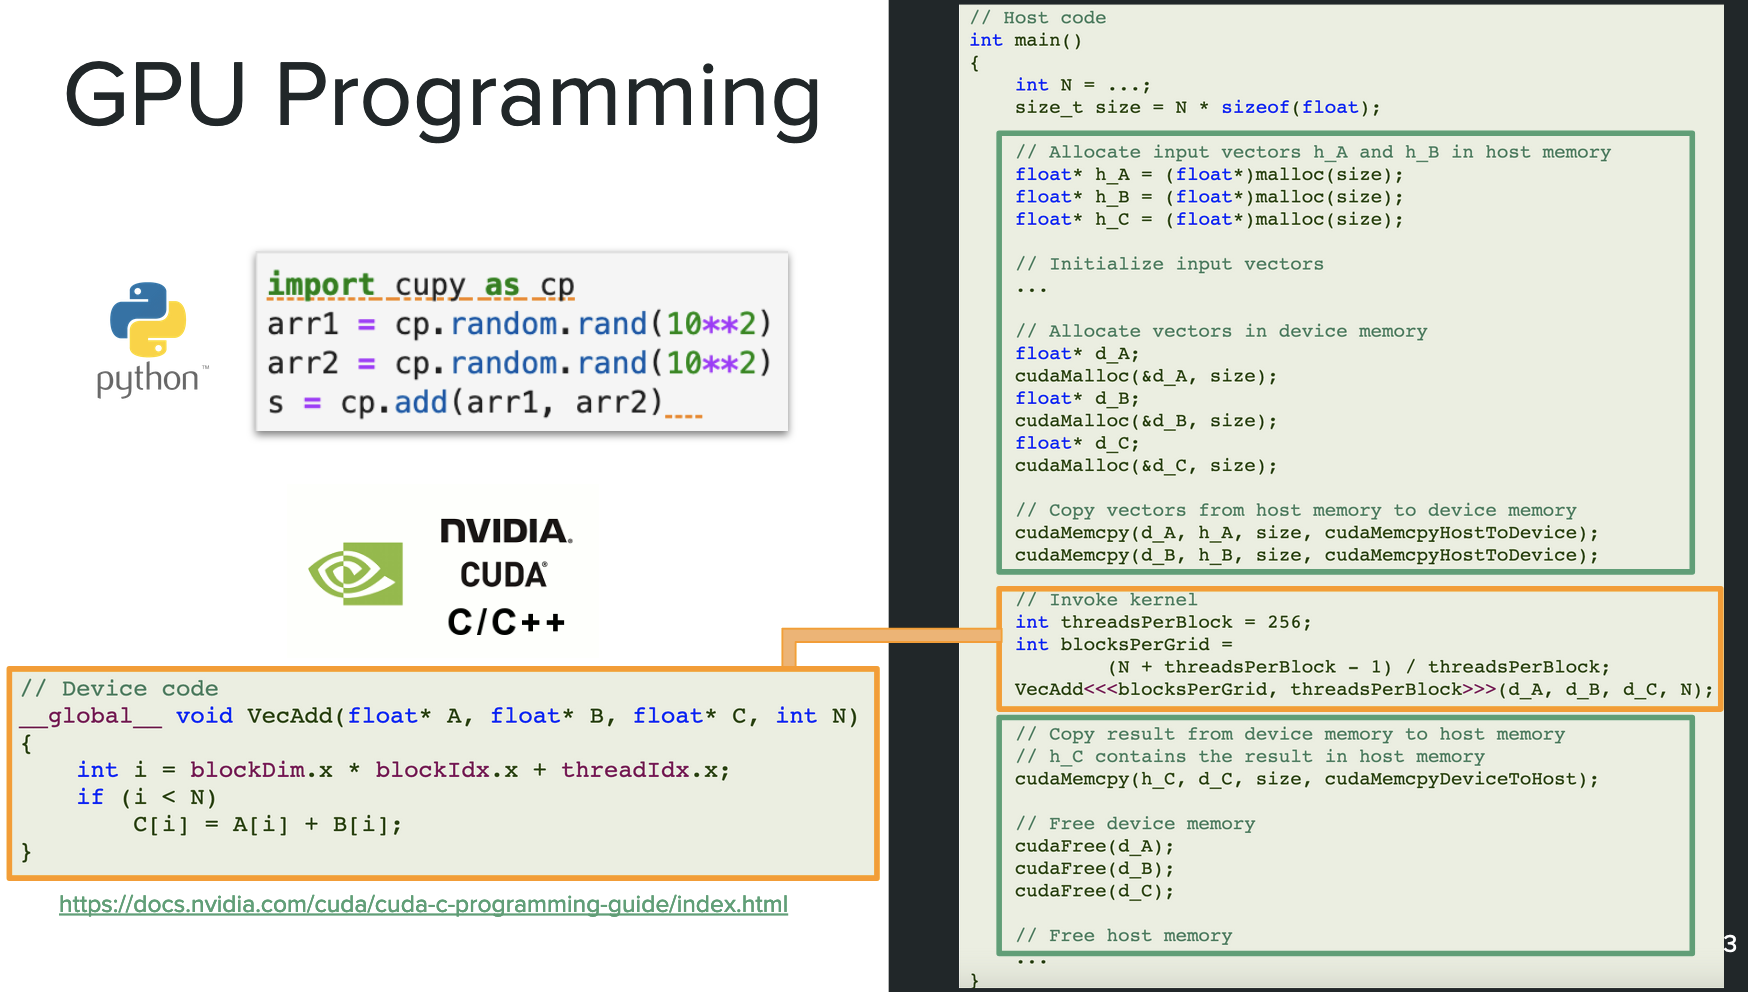
*Source: NCAR SIParCS 2022 Haniye Kashgarani (Implementation of GeoCat on GPUs)*

Some of the considerations for compiled languages that are potentially hidden from simple Python implementations:
  - Memory movement
  - Instruction flow
  - Loop control
  - ?
  
### Performance
**Cython**
Compiled Python and the Just-in-Time (JIT) functionality of Python to compiled code.

Awareness of memory location, memory management, synchronization, and porting choices are still the responsibility of the implementer.

### Portability

# CuPy

## Overview

CuPy is a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python. CuPy acts as a drop-in replacement to run existing NumPy/SciPy code on NVIDIA CUDA or AMD ROCm platforms.

CuPy provides a ndarray, sparse matrices, and the associated routines for GPU devices, all having the same API as NumPy and SciPy.


## Setup

At the most basic setup, all you need to do is import the CuPy library in your Python file:

```python
import cupy as cp
```

Then use `cp` instead of Numpy's standard `np` to create arrays and perform computations.

Import the CuPy library and create a few arrays:


In [2]:
import cupy as cp
import numpy as np

In [3]:
# NumPy data
x_cpu = np.linspace(0, 2, 5)
print("On the CPU: ", x_cpu)

# CuPy data
x_gpu = cp.linspace(2, 4, 5)
print("On the GPU: ", x_gpu)

On the CPU:  [0.  0.5 1.  1.5 2. ]
On the GPU:  [2.  2.5 3.  3.5 4. ]


One option to determine if CuPy is available is to check during import.  This method checks if CuPy is available and avoids errors on run if it isn't. 

```python
def _import_cupy():
    """imports the cupy and checks if not installed"""
    try:
        import cupy as cp
        return cp
    except ImportError as e:
        print(f"Cupy is not installed for GPU computation!")
        pass  # module doesn't exist, deal with it. 
```

*Source: Haniye Kashgarani SIParCS GeoCat GPU Project*

----

Move data between host and device

In [3]:
# Move data to GPU
x_gpu = cp.asarray(x_cpu)

# Move data back to host
x_cpu = cp.asnumpy(x_gpu)

Identify and use devices with CuPy

[Comparison of Numpy and Scipy to CuPy functions](https://docs.cupy.dev/en/stable/reference/comparison.html)

## Developing for CPUs and GPUs

### Development Environment


CuPy has the ability to identify array types to write device agnostic code.  Below is a code sample using the community standard for reading an array and setting the package to use either Numpy or Cupy based on the type.

```python
xp = cp.get_array_module(x)
xp.linspace(0, 2, 5)
```

In [72]:
# Vector Add 1D implementation
def vecadd(x):
    xp = cp.get_array_module(x)  # 'xp' is a standard usage in the community
    print("Using:", xp.__name__)
    return x+1


# Calls and Output
print(vecadd(x_cpu))
# print(softplus(x_gpu))

Using: numpy
[1.  1.5 2.  2.5 3. ]


There are other methods to consider when writing CPU and GPU compatible code:
  - Separate development branches for GPU code
  - Implementing GPU Flags within code to use the GPU portion of your code
  - Writing scripts to move all data to the GPU
 
You may also need to consider new unit tests to verify your GPU code does not inject any unexpected behavior both on the CPU and GPU side.

## CuPy with SciPy

Here we want to show an example of easily porting a short script to run on the GPU.  We'll use CuPy's SciPy functionality to analyze the frequency content of a time series dataset.


### Spectral Analysis of Time Series Data

We can use the Fast Fourier Transform on a set of time series data to perform spectral analysis and identify potential periodicities.  The Discrete Fourier Transform can be called using the CuPy API:

```python
cupyx.scipy.fft.ifft(x, n=None, axis=- 1, norm=None, overwrite_x=False, *, plan=None)
```


### The Gravity Recovery and Climate Experiment (GRACE) Dataset

**Main takeaway:** Walk through small code section that shows the basic steps of drop-in replace

Refers to a pair of NASA satellites that has flown in low-Earth orbit since 2002.


Time series data representation of mean annual amplitude of total water storage in a 200km square area near Colorado:


In [6]:
import matplotlib.pyplot as plt

In [8]:
# Pull in the time series data
data_cpu = np.loadtxt("code/gracets/data/grace_raw.o")

Text(0, 0.5, 'GRACE Annual Amplitude (mm)')

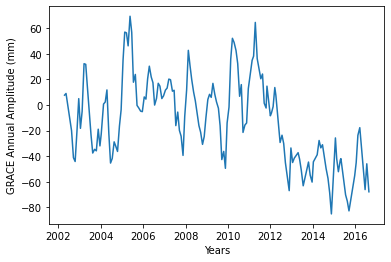

In [9]:
# Plot TS
x = data_cpu[:,0]
y = data_cpu[:,1]
ts = plt.plot(x, y)
plt.xlabel("Years")
plt.ylabel("GRACE Annual Amplitude (mm)")

In [ ]:
# Perform DFFT (cpu)


In [ ]:
# Transfer data to GPU
data_gpu = cp.copy(data_cpu)

In [ ]:
# Perform DFFT (gpu)


In [ ]:
# Plot DFFT


In [ ]:
# Plot performance differences


**Current SciPy implementations for CuPy:**
[SciPy API](https://docs.cupy.dev/en/stable/reference/index.html)

**GRACE Source:** Swenson, Sean & National Center for Atmospheric Research Staff (Eds). Last modified 08 Oct 2013. "The Climate Data Guide: GRACE: Gravity Recovery and Climate Experiment: Surface mass, total water storage, and derived variables." Retrieved from https://climatedataguide.ucar.edu/climate-data/grace-gravity-recovery-and-climate-experiment-surface-mass-total-water-storage-and.

## GeoCat Example

NCAR's GeoCat team has started exploring the potential of porting computational meteorological code to run on GPUs.  The relative humidity computations have been tested to run on single GPUs alongside the standard NumPy version.

  - **Main takeaway**: Show real implementation in earth science and process to identify, benchmark, iterate on GPU problem
  - Show opportunities to expand existing Packages like Xarray
  - Show opportunity to contribute

[GeoCAT-comp RelHum-CuPy branch](https://github.com/haniyeka/geocat-comp/tree/relhum_cupy)

[GeoCat Homepage](https://geocat.ucar.edu/)

## Computational Fluid Dynamics (CFD) Example

Let's look at an example where you might expect performance improvements by running it on the GPU.


### Cavity Flow Navier Stokes
Using the [12 Steps to CFD](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/) tutorial series, we can test Navier Stokes equations to run on both CPU and GPU to compare runtimes in Python.  
  - Show how the problem or grid size determines if it is worthwile to run on the GPU.  
  - Show an implementation 
  - Show benchmarking and path to optimization 

In the `code` folder there are several Python files used to create these results.  

|Folder |File |Description |
|:--- |:--- |:--- |
|Numpy   |                             |                                         |
|        | step11_numpy.py                | cpu numpy using float       |
|        | step11_numpy_double.py         | cpu numpy using double              |
|Cupy    |                             |                                         |
|        | step11_cupy.py              | cpu/gpu agnostic with gpu flag using float   |
|        | step11_cupy_double.py       | cpu/gpu agnostic with gpu flag using double  |


### CPU Implementation

Below we initialize the data used in our application with Numpy.  This will run on the CPU as use whatever default Numpy optimizations:

```python
    def _init_params(self, n):
        # NumPy setup
        self.x = np.linspace(0, 2, n)
        self.y = np.linspace(0, 2, n)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.u = np.zeros((n, n))
        self.v = np.zeros((n, n))
        self.p = np.zeros((n, n))         
        self.un = np.empty_like(self.u)
        self.vn = np.empty_like(self.v)
        self.pn = np.empty_like(self.p)
        self.b = np.zeros((n, n)) 
```

It should be noted that even the Numpy CPU implementation hides the computational heavy lifting unless you look for it.  Here is an example of uncertainity in how many threads Numpy will use by default:

https://stackoverflow.com/questions/30791550/limit-number-of-threads-in-numpy

### Basic GPU Port

Here we'll use the device agnostic method and a flag to determine how to allocate the data, either with Numpy on the host (CPU) or CuPy on the device (GPU).  Drop-in, device agnostic replacement:
  
```python

    class CavityFlow(object):
        # ...
        
    def __init__(self, dims, timesteps, use_gpu=False):
        # ...
        
    def _init_params(self, n):
        # CuPy setup
        if self.use_gpu:
            xp = cp
        else:
            xp = np

        self.x = xp.linspace(0, 2, n)
        self.y = xp.linspace(0, 2, n)
        self.X, self.Y = xp.meshgrid(self.x, self.y)
        self.u = xp.zeros((n, n))
        self.v = xp.zeros((n, n))
        self.p = xp.zeros((n, n))         
        self.un = xp.empty_like(self.u)
        self.vn = xp.empty_like(self.v)
        self.pn = xp.empty_like(self.p)
        self.b = xp.zeros((n, n))
        
```



    
```python  

    print(benchmark(launch_test, (n, ts, use_gpu), n_repeat=20, n_warmup=5))
    
    launch_test         :    
        CPU:6149582.250 us   +/-57936.881 (min:6057903.693 / max:6283134.224) us                     
      GPU-0:6149643.408 us   +/-57938.509 (min:6057958.008 / max:6283191.406) us
``` 

----

### Import additional modules

In [7]:
from matplotlib import pyplot, cm
import time

### Class and Functions

In [33]:
# Cavity Flow Class
class CavityFlow(object):

    def __init__(self, dims, timesteps, use_gpu, plot_result):
        # Parameter Initialization
        self.n = dims
        self.nt = timesteps
        self.use_gpu = use_gpu
        self.plot_result = plot_result
        self.nit = 50
        self.c = 1
        self.dx = 2 / (self.n-1)
        self.dy = 2 / (self.n-1)
        self.rho = 1
        self.nu = 0.1
        self.dt = 0.0001

        self._init_params(self.n)

    def _init_params(self, n):
        # CuPy setup
        if self.use_gpu:
            xp = cp
        else:
            xp = np

        self.x = xp.linspace(0, 2, n, dtype=xp.double)
        self.y = xp.linspace(0, 2, n, dtype=xp.double)
        self.X, self.Y = xp.meshgrid(self.x, self.y)
        self.u = xp.zeros((n, n), dtype=xp.double)
        self.v = xp.zeros((n, n), dtype=xp.double)
        self.p = xp.zeros((n, n), dtype=xp.double)         
        self.un = xp.empty_like(self.u, dtype=xp.double)
        self.vn = xp.empty_like(self.v, dtype=xp.double)
        self.pn = xp.empty_like(self.p, dtype=xp.double)
        self.b = xp.zeros((n, n), dtype=xp.double)

    def plot(self):
        fig = pyplot.figure(figsize=(11,7), dpi=100)
        # plotting the pressure field as a contour
        pyplot.contourf(self.X, self.Y, self.p, alpha=0.5, cmap=cm.viridis)  
        pyplot.colorbar()
        # plotting the pressure field outlines
        pyplot.contour(self.X, self.Y, self.p, cmap=cm.viridis)  
        # plotting velocity field
        pyplot.quiver(self.X[::2, ::2], self.Y[::2, ::2], self.u[::2, ::2], self.v[::2, ::2]) 
        pyplot.xlabel('X')
        pyplot.ylabel('Y')
        pyplot.title('Cavity Flow')

    def _build_up_b(self): 
        self.b[1:-1, 1:-1] = (self.rho * (1 / self.dt * 
                             ((self.u[1:-1, 2:] - self.u[1:-1, 0:-2]) / 
                             (2 * self.dx) + (self.v[2:, 1:-1] - self.v[0:-2, 1:-1]) / (2 * self.dy)) -
                             ((self.u[1:-1, 2:] - self.u[1:-1, 0:-2]) / (2 * self.dx))**2 -
                             2 * ((self.u[2:, 1:-1] - self.u[0:-2, 1:-1]) / (2 * self.dy) *
                             (self.v[1:-1, 2:] - self.v[1:-1, 0:-2]) / (2 * self.dx))-
                             ((self.v[2:, 1:-1] - self.v[0:-2, 1:-1]) / (2 * self.dy))**2))

    def _pressure_poisson(self):
        self.pn = cp.copy(self.p)
        for q in range(self.nit):
            self.pn = self.p.copy()
            self.p[1:-1, 1:-1] = (((self.pn[1:-1, 2:] + self.pn[1:-1, 0:-2]) * self.dy**2 + 
                                 (self.pn[2:, 1:-1] + self.pn[0:-2, 1:-1]) * self.dx**2) /
                                 (2 * (self.dx**2 + self.dy**2)) -
                                 self.dx**2 * self.dy**2 / (2 * (self.dx**2 + self.dy**2)) * 
                                 self.b[1:-1,1:-1])

            # dp/dx = 0 at x = 2
            self.p[:, -1] = self.p[:, -2]
            # dp/dy = 0 at y = 0
            self.p[0, :] = self.p[1, :]
            # dp/dx = 0 at x = 0
            self.p[:, 0] = self.p[:, 1]
            # p = 0 at y = 2 
            self.p[-1, :] = 0

    def compute(self):
        for n in range(self.nt):
            un = cp.copy(self.u)
            vn = cp.copy(self.v)
            self._build_up_b()
            self._pressure_poisson()
            self.u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                             un[1:-1, 1:-1] * self.dt / self.dx *
                            (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                             vn[1:-1, 1:-1] * self.dt / self.dy *
                            (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                             self.dt / (2 * self.rho * self.dx) * (self.p[1:-1, 2:] - self.p[1:-1, 0:-2]) +
                             self.nu * (self.dt / self.dx**2 *
                            (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                             self.dt / self.dy**2 *
                            (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

            self.v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                             un[1:-1, 1:-1] * self.dt / self.dx *
                            (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                             vn[1:-1, 1:-1] * self.dt / self.dy *
                            (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                             self.dt / (2 * self.rho * self.dy) * (self.p[2:, 1:-1] - self.p[0:-2, 1:-1]) +
                             self.nu * (self.dt / self.dx**2 *
                            (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                             self.dt / self.dy**2 *
                            (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

            self.u[0, :]  = 0
            self.u[:, 0]  = 0
            self.u[:, -1] = 0
            # Set velocity on cavity lid equal to 1
            self.u[-1, :] = 1
            self.v[0, :]  = 0
            self.v[-1, :] = 0
            self.v[:, 0]  = 0
            self.v[:, -1] = 0
        if (self.plot_result):
            self.plot()

Set up timing for compute section:

In [25]:
def launch_test(n, ts, use_gpu=False, plot_result=False):
    start_datamv = time.perf_counter()
    flow = CavityFlow(n, ts, use_gpu, plot_result)
    end_datamv = time.perf_counter()
    if (use_gpu):
        start_gpu = time.perf_counter()
        flow.compute()
        end_gpu = time.perf_counter()
        t_gpu = end_gpu - start_gpu
        total_time = (end_datamv - start_datamv) + t_gpu
        print("--- Cavity Flow Performance Test ---")
        print("Dimension: ", n, "\nTimesteps: ", ts, "\nGPU Run")
        print("Computation Time: ", t_gpu, "\nTotal Time: ", total_time, "\n")
    else:
        start_cpu = time.perf_counter()
        flow.compute()
        end_cpu = time.perf_counter()
        t_cpu = end_cpu - start_cpu
        total_time = (end_datamv - start_datamv) + t_cpu
        print("--- Cavity Flow Performance Test ---")
        print("Dimension: ", n, "\nTimesteps: ", ts, "\nCPU Run")
        print("Computation Time: ", t_cpu, "\nTotal Time: ", total_time, "\n")

### Launching Tests

Start the test with input for gridsize (n) and timesteps (ts).  Feel free to re-run the code with your own inputs for gridsize and timesteps to see performance results.  The simulation is sensitive to the ratio of dx/dt, so be mindful that very large grid sizes could cause the simulation to go out of bounds.

The cavity flow code can be parallelized over the grid size but not over the timesteps.  Modifying timesteps in it's current state will see increase in runtime but not parallelization. 

--- Cavity Flow Performance Test ---
Dimension:  41 
Timesteps:  100 
CPU Run
Computation Time:  0.16555178258568048 
Total Time:  0.1658026436343789 

--- Cavity Flow Performance Test ---
Dimension:  41 
Timesteps:  100 
GPU Run
Computation Time:  1.274270768277347 
Total Time:  1.2745993454009295 



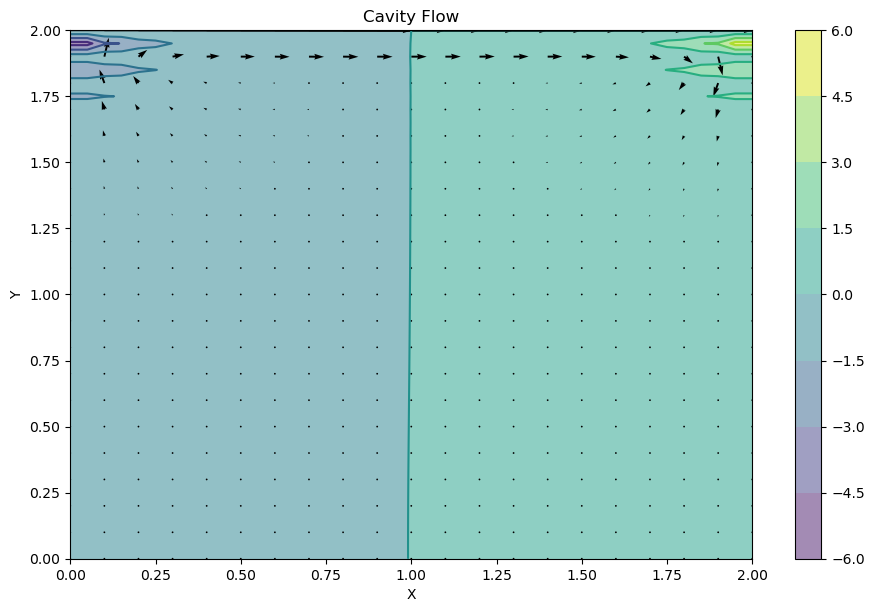

In [34]:
# 41x41 Grid, 100 Timesteps
n = 41
ts = 100
launch_test(n, ts, use_gpu=False, plot_result=True)
launch_test(n, ts, use_gpu=True)

In [27]:
# 512x512 Grid, 100 Timesteps
n = 256
ts = 100
launch_test(n, ts, use_gpu=False, plot_result=True)
launch_test(n, ts, use_gpu=True)

--- Cavity Flow Performance Test ---
Dimension:  256 
Timesteps:  100 
CPU Run
Computation Time:  2.73828212171793 
Total Time:  2.738838715478778 

--- Cavity Flow Performance Test ---
Dimension:  256 
Timesteps:  100 
GPU Run
Computation Time:  1.3499203035607934 
Total Time:  1.3503440311178565 



### Plotting Results

Increasing grid size 
    
![step11_results](img/step11_results1.png)

Increasing timesteps

![step11_increased_timesteps](img/step11_incts.png)

### Advanced Profiling

CuPy includes Nvidia Tools Extension (NVTX) profiling capabilities that can be imported from the `cupyx.profiler` module.  This allows you to flag and label a function when running the Nsight Systems profiler for your GPU application.

Nsight Systems benchmarking and setting time ranges in the Python code: 

```python
    from cupyx.profiler import time_range, benchmark 

    @time_range()
    def compute(self):
        ...
```

To run the Nsys profiler with on your Python GPU application, run the following within your terminal window:
        
```sh
    ### Run
    nsys profile -o step11_profile python step11_benchmark.py -t cuda,cublas,nvtx -f true
```

The results for a profiled run of 128 gridsize (n) and 500 timesteps (ts) is shown below.  The arguments genereate a profile report called *step11_profile* from the *step11_benchmark.py* Python file, and will trace Cuda, Cublas, and NVTX events when profiling the application.  A detailed overview of the profiler arguments can be found in a previous workshop session.

Nsight Systems generated a report with file extension `.qdrep`.  You can also view this generated report (*step11_profile.qdrep*) in the `code/cfd/cupy` folder if you have previously installed Nsight Systems.  Right click on the file to download it to your local machine.

Nsight Systems GUI viewing the profiled application report:
![nsys_step11.png](img/nsys_step11.png)

### Memory Optimization
  - Pin memory.
  - Cache setup.
  - Reduce transfers between CPU and GPU.
  - Benchmark.

### Algorithm Optimization
  - Custom Kernel.
  - Streams.
  - Benchmark.

## Advanced CuPy

Custom Kernels
  - Simple example of kernel vector add
  
Distributed Communication package
  - cupyx.distributed
  
Memory management and scaling up or out
  - Dask plus memory considerations in next session
  - What options do you have when problem sizes are larger than memory limit?
  

## ?REMOVE Memory Management

Memory pool: Python manages memory spaces and operations

CuPy uses memory pool for memory allocations by default. The memory pool significantly improves the performance by mitigating the overhead of memory allocation and CPU/GPU synchronization.

There are two different memory pools in CuPy:
  - Device memory pool (GPU device memory), which is used for GPU memory allocations.
  - Pinned memory pool (non-swappable CPU memory), which is used during CPU-to-GPU data transfer.


# Legate

Legate is another option for drop-in replacement for accelerated Python GPU code.  Numpy and Pandas are supported for drop-in replacement via Legate.cuNumerics and Legate.Pandas, respectively. 

Legate's approach to Python GPU acceleration:

  1) The programming model must be identical to programming a single sequential CPU on their laptop or desktop. All concerns relating to parallelism, data distribution, and synchronization must be implicit. 
  2) Software must be compositional and not just interoperable (i.e. functionally correct). Libraries developed in the Legate ecosystem must be able to exchange partitioned and distributed data without requiring "shuffles" or unnecessary blocking synchronization.
 
These two core concepts of Legate reduce the effort of the developer and shifts the memory management responsibilities onto the backend of the Legate Core API.

## Setup

Documentation on downloading and installing Legate can be found here:

https://github.com/nv-legate/legate.core

After this, you can use the legate driver script in the bin directory of your installation to run any Python program. Note that the default python interpreter (python) will not work with programs that use Legate libraries, you need to use this custom driver script.

For example, to run your script in the default configuration (4 CPUs cores and 4 GB of memory) just run:

``` Python
installdir/bin/legate my_python_program.py [other args]
```

## Implementation

All Legate tasks are currently implemented in native C or CUDA

## Limitations

Accelerators such as GPUs achieve significantly higher performance when computations are performed asynchronously with respect to other components of the system.  Legate has to perform what is called pessimistic synchronization between data that may not be within Legate generated memory.

## CuNumerics

## Basic Drop-in

After installing the Legate Core library, the next step is to install a Legate application library such as cuNumeric. The installation process for a Legate application library will require you to provide a pointer to the location of your Legate Core library installation as this will be used to configure the installation of the Legate application library. After you finish installing any Legate application libraries, you can then simply replace their import statements with the equivalent ones from any Legate application libraries you have installed. For example, you can change this:

```python
import numpy as np
```

to this:

```python
import cunumeric as np
```

## Bin setup



## Legate.Pandas

# Resources

[CuPy Website and Documentation](https://docs.cupy.dev/en/stable/index.html)

[12 Steps to CFD GitHub](https://github.com/barbagroup/CFDPython)

[12 Steps to CFD Main page](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)

[GRACE Data NCAR](https://climatedataguide.ucar.edu/climate-data/grace-gravity-recovery-and-climate-experiment-surface-mass-total-water-storage-and)

[GRACE Data CU](http://geoid.colorado.edu/grace/index.html)

[Python Intrepreter and How Python Works](https://towardsdatascience.com/how-does-python-work-6f21fd197888)

[Legate](https://github.com/nv-legate)